In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Define Projection Matrix for continious optimization

In [2]:
def Projection_matrix(X, t, delta):
    T0 = np.diag(t)
    convex1 = T0 @ X.T @ X @ T0
    I = np.eye(T0.shape[0])
    convex2 =  delta * (I - T0 @ T0)
    p_term = convex1 + convex2
    Pt = X @ T0 @ np.linalg.inv(p_term) @ T0 @ X.T
    return Pt

### Objective function or the Lagrangian

In [3]:
def objective(X, t, delta, lambda_):
    Pt = Projection_matrix(X, t, delta)
    trace_term = -np.trace(X.T @ Pt @ X)
    regularization_term = lambda_ * np.sum(t)
    return trace_term + regularization_term

### Computing the matrices required for gradient

In [4]:
def compute_matrices(X, t, delta):
    T0 = np.diag(t)
    K = X.T @ X
    Z = K - delta * np.eye(K.shape[0])
    Lt = T0 @ Z @ T0 + delta * np.eye(T0.shape[0])
    return K, Z, Lt, T0

def compute_phi(X, t, delta, lambda_, M):
    K, Z, Lt, T0 = compute_matrices(X, t, delta)
    phi_samples = []
    for _ in range(M):
        # Rademacher distribution
        z = np.random.choice([-1, 1], size=(K.shape[0],))  
        a = K @ z
        b = np.linalg.inv(Lt) * (t * a)  # Element-wise multiplication
        phi = (b * (Z @ (t * b))) - (a * b)  
        phi_samples.append(phi)
    phi_mean = np.mean(phi_samples, axis=0)
    return phi_mean

### Computing gradient using Monte Carlo size M approximation

In [5]:
def gradient(X, t, delta, lambda_, M):
    phi_mean = compute_phi(X, t, delta, lambda_, M)
    gradient = 2 * (1 / M) * phi_mean + lambda_ * np.eye(X.shape[1])
    return np.diag(gradient)

### Non linear transformation from t to w

In [6]:
def t_to_w(t):
    return np.sqrt(-np.log(1 - t))

def w_to_t(w):
    return 1 - np.exp(-(w**2))

### Gradient Descent Algorithm

In [7]:
def gradient_descent(X, w_init, delta, lambda_, learning_rate, max_iter, M):
    w = w_init
    
    for i in range(max_iter):
        grad = gradient(X, w, delta, lambda_, M)
        w -= learning_rate * grad
        t = w_to_t(w)
        
        if i % 100 == 0:
            print(f"Iteration {i}: t = {t}")
            print("\n")
            print(f"Iteration{i}: Objective Value={objective(X, w, delta, lambda_)}")
            print("\n")
        
    return w

### Optimal value of t for small dataset 

In [25]:
np.random.seed(0)
# Import data (small dataset)
df = pd.read_csv("D2XL1.csv")
X = df.values 

n = X.shape[1]  
m = X.shape[0]  

# Initialize t and w
t_init = np.full(n, 0.5)  
w_init = np.sqrt(-np.log(1 - t_init))

# Constants
delta = 1
lambda_ = 1
learning_rate = 0.00001
max_iter = 1000
M = 5  # Monte Carlo sample size

# Optimized w and t using gradient descent
optimized_w = gradient_descent(X, w_init, delta, lambda_, learning_rate, max_iter, M)
print("Optimized w:", optimized_w)
print("\n")
print("Optimized t:", w_to_t(optimized_w))

Iteration 0: t = [0.50250896 0.57186874 0.50147198 0.50001565 0.4999988  0.53893489
 0.56105114 0.57281518 0.52993947 0.57033448 0.57815865 0.52373797
 0.53287367 0.50827644 0.51347086 0.50017448]


Iteration0: Objective Value=-379159.6157963624


Iteration 100: t = [1.         1.         1.         0.99999992 0.49377481 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


Iteration100: Objective Value=-379113.5555219474


Iteration 200: t = [1.         1.         0.99999999 0.99989732 0.48741005 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


Iteration200: Objective Value=-379591.6809315111


Iteration 300: t = [0.78335331 1.         0.5543835  0.9558786  0.48116245 1.
 1.         1.         1.         1.         1.         1.
 1.         0.8783644  0.97759938 1.        ]


Iteration300: Objective Value=-379528.30315875536


Iteration 400: t = [1.         1.         0

In [9]:
"""
Note that the t[i]'s with value less than 0.5 are the i'th columns of X to be dropped. 
In general we can  define a threshold for which t[i] < threshold implies the above. 
In the paper they have taken this threshold value as 0.5. 
So our final result of optimized t tells us to drop columns 4 and 5, or the two correlated columns. 

The values of lambda and delta depends on data. The paper mentions d = 1 as optimal, and do a grid search for value of lambda. 

"""


"\nNote that the t[i]'s with value less than 0.5 are the i'th columns of X to be dropped. \nIn general we can  define a threshold for which t[i] < threshold implies the above. \nIn the paper they have taken this threshold value as 0.5. \nSo our final result of optimized t tells us to drop columns 4 and 5, or the two correlated columns. \n\nThe values of lambda and delta depends on data. The paper mentions d = 1 as optimal, and do a grid search for value of lambda. \n\n"

### Hyper parameter tuning for lambda

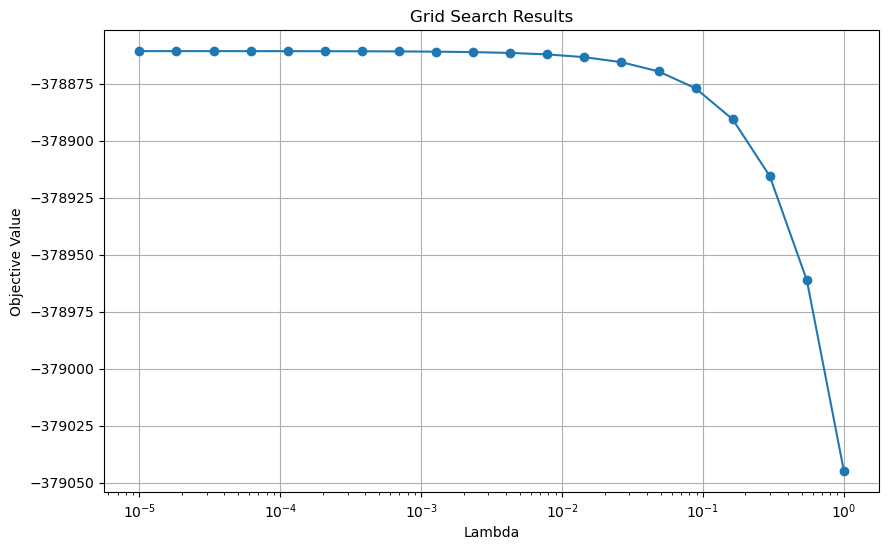

In [19]:
def grid_search(X, w_init, delta, lambdas, learning_rate, max_iter, M):
    results = []
    for lambda_ in lambdas:
        obj_value = objective(X, optimized_w, delta, lambda_)  
        results.append((lambda_, obj_value))
    return results

lambda_values = np.logspace(-5, 0, 20)

results = grid_search(X, w_init, delta, lambda_values, learning_rate, max_iter, M)

lambdas, objective_values = zip(*results)
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, objective_values, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Objective Value')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()

In [ ]:
"""
Lambda = 1 seems optimal from the figure
"""

In [ ]:
d